PreAgg: NNM, Aggregator: trimmed_mean, Byzantine ratio: 0%, Accuracy: 97.85%
PreAgg: NNM, Aggregator: trimmed_mean, Byzantine ratio: 10%, Accuracy: 97.63%
PreAgg: NNM, Aggregator: trimmed_mean, Byzantine ratio: 20%, Accuracy: 37.35%
PreAgg: NNM, Aggregator: trimmed_mean, Byzantine ratio: 30%, Accuracy: 10.31%
PreAgg: NNM, Aggregator: trimmed_mean, Byzantine ratio: 40%, Accuracy: 10.93%


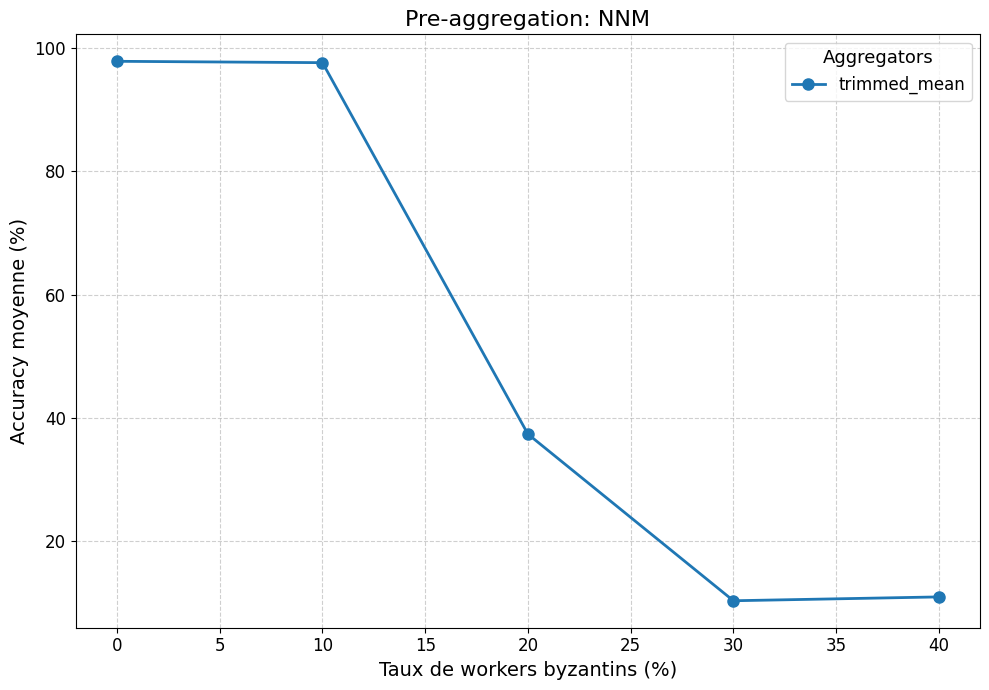

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms
import random
import numpy as np
import matplotlib.pyplot as plt
import byzfl
import torch.nn.functional as F
import copy

# ------------------------------------------------------------------------------
# Fusionne les intervalles qui se chevauchent ou sont adjacents.
def merge_intervals(intervals):
    if not intervals:
        return []
    intervals.sort()
    merged = [intervals[0]]
    for current in intervals[1:]:
        last = merged[-1]
        if current[0] <= last[1]:
            merged[-1] = (last[0], max(last[1], current[1]))
        else:
            merged.append(current)
    return merged

def generate_gaussian_availability(total_time_steps, worker_id, num_workers, std_dev_ratio=0.1, min_processing_time=3):
    # Trois pics définis (matin, après-midi, soir)
    peak_means = [0.25, 0.5, 0.75]  # en proportion du total
    std_dev = int(std_dev_ratio * total_time_steps)

    availability_periods = []
    for mean_ratio in peak_means:
        mean = int(mean_ratio * total_time_steps)
        intensity = random.choice([1, 2, 3])  # intensité aléatoire
        for _ in range(intensity):
            start_time = int(np.random.normal(loc=mean, scale=std_dev))
            start_time = max(0, min(start_time, total_time_steps - min_processing_time))
            max_extra = 2 * intensity
            duration = random.randint(min_processing_time, min(min_processing_time + max_extra, total_time_steps - start_time))
            end_time = start_time + duration
            availability_periods.append((start_time, end_time))
    return merge_intervals(availability_periods)

def generate_gaussian_byzantine_availability(total_time_steps, worker_id, num_workers, std_dev_ratio=0.08, min_processing_time=2):
    # Disponibilité byzantine : pics dans les heures creuses uniquement.
    off_peak_means = [0.1, 0.375, 0.9]  # en proportion
    std_dev = int(std_dev_ratio * total_time_steps)
    availability_periods = []
    for mean_ratio in off_peak_means:
        mean = int(mean_ratio * total_time_steps)
        intensity = random.choice([1, 1, 2])
        for _ in range(intensity):
            start_time = int(np.random.normal(loc=mean, scale=std_dev))
            start_time = max(0, min(start_time, total_time_steps - min_processing_time))
            max_extra = 1 * intensity
            duration = random.randint(1, min(min_processing_time + max_extra, total_time_steps - start_time))
            end_time = start_time + duration
            availability_periods.append((start_time, end_time))
    return merge_intervals(availability_periods)

# ------------------------------------------------------------------------------
# Définition du modèle de réseau de neurones
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class LeNetLike(nn.Module):
    def __init__(self):
        super(LeNetLike, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  
        x = self.pool(F.relu(self.conv2(x)))  
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# ------------------------------------------------------------------------------
# Gestionnaire de batch avec SubsetRandomSampler
class BatchManager:
    def __init__(self, dataset, batch_size):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indices = list(range(len(dataset)))
        random.shuffle(self.indices)
        self.sampler = SubsetRandomSampler(self.indices)
        self.loader = iter(DataLoader(self.dataset, batch_size=self.batch_size, sampler=self.sampler))
    def get_next_batch(self):
        try:
            return next(self.loader)
        except StopIteration:
            random.shuffle(self.indices)
            self.sampler = SubsetRandomSampler(self.indices)
            self.loader = iter(DataLoader(self.dataset, batch_size=self.batch_size, sampler=self.sampler))
            return next(self.loader)

# ------------------------------------------------------------------------------
# Classe de Worker (incluant l'attribut blocked)
class Worker:
    def __init__(self, model, device, worker_id, availability_periods, processing_time):
        self.device = device
        self.worker_id = worker_id
        self.availability_periods = availability_periods
        self.processing_time = processing_time
        self.model = model.to(device)
        self.criterion = nn.CrossEntropyLoss()
        self.finish_time = None
        self.current_batch_info = None  # (complete_batch_id, mini_batch_id)
        self.blocked = False  # Worker actif par défaut

    def is_available(self, current_time):
        if self.blocked:
            return False
        for start_time, end_time in self.availability_periods:
            if start_time <= current_time < end_time:
                if self.finish_time is None or current_time >= self.finish_time:
                    return (current_time + self.processing_time) <= end_time
        return False

    def start_computation(self, current_time, batch_info, data, targets):
        if self.current_batch_info is None or self.current_batch_info != batch_info:
            self.current_batch_info = batch_info
            self.finish_time = current_time + self.processing_time
            return self.compute_gradient(data, targets)
        return None

    def has_finished(self, current_time):
        return self.finish_time == current_time

    def compute_gradient(self, data, targets):
        data, targets = data.to(self.device), targets.to(self.device)
        self.model.zero_grad()
        outputs = self.model(data)
        loss = self.criterion(outputs, targets)
        loss.backward()
        gradients = {name: param.grad.detach().clone() for name, param in self.model.named_parameters()}
        return gradients, self.current_batch_info

    def update_model(self, model_state_dict):
        self.model.load_state_dict(model_state_dict)

# ------------------------------------------------------------------------------
# Worker byzantin qui renvoie un gradient corrompu
class ByzantineWorker(Worker):
    def compute_gradient(self, data, targets):
        corrupted_gradients = {}
        for name, param in self.model.named_parameters():
            corrupted_gradients[name] = torch.full_like(param, 1e6)
        return corrupted_gradients, self.current_batch_info

# ------------------------------------------------------------------------------
# Serveur gérant les batchs, la vérification et l'agrégation
class Server:
    def __init__(self, dataset, batch_size=64, mini_batch_size=16, lr=0.005, verbose=False,
                 aggregation_strategy='trimmed_mean', f=0, preagg=None):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = LeNetLike().to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.batch_manager = BatchManager(dataset, batch_size)
        self.mini_batch_size = mini_batch_size
        self.current_complete_batch = None
        self.current_batch_id = 0
        self.current_mini_batches = {}
        # Pour chaque mini-batch, on stocke (gradients, worker_id)
        self.received_gradients = {}
        self.verbose = verbose
        self.aggregation_strategy = aggregation_strategy
        self.f = f
        self.preagg = preagg
        self.checkpoints = {}  # stocke les états sauvegardés pour chaque mini-batch
        # Dictionnaire worker_id -> worker (sera assigné dans l'expérience)
        self.worker_dict = {}
        self.criterion = nn.CrossEntropyLoss()

    def get_new_complete_batch(self, current_time):
        data, targets = self.batch_manager.get_next_batch()
        self.current_complete_batch = (data, targets)
        self.current_batch_id += 1
        num_samples = data.size(0)
        mini_batches = []
        for i in range(0, num_samples, self.mini_batch_size):
            mini_data = data[i: i + self.mini_batch_size]
            mini_targets = targets[i: i + self.mini_batch_size]
            mini_batches.append((mini_data, mini_targets))
        self.current_mini_batches = {i: mini_batches[i] for i in range(len(mini_batches))}
        self.received_gradients = {}
        if self.verbose:
            print(f"[Temps {current_time}] Batch complet {self.current_batch_id} divisé en {len(mini_batches)} mini-batches.")
        # Sauvegarde initiale (checkpoint) pour chaque mini-batch
        for idx in self.current_mini_batches:
            self.checkpoints[idx] = copy.deepcopy(self.model.state_dict())

    def register_gradient(self, gradients, batch_info, worker_id, current_time, worker_processing_time):
        batch_id, mini_idx = batch_info
        if batch_id != self.current_batch_id:
            return
        if mini_idx in self.received_gradients:
            if self.verbose:
                print(f"[Temps {current_time}] Doublon pour mini-batch {mini_idx} par worker {worker_id}.")
            return
        # Enregistrer le gradient et l'ID du worker
        self.received_gradients[mini_idx] = (gradients, worker_id)
        if self.verbose:
            print(f"[Temps {current_time}] Gradient accepté pour mini-batch {mini_idx} (batch {batch_id}) par worker {worker_id}.")

    def verify_mini_batch(self, mini_idx, current_time, verification_prob=0.3):
        """
        Vérifie un mini-batch avec une probabilité donnée.
        La vérification se fait à partir du checkpoint stocké pour ce mini-batch.
        Si la simulation d'update montre une augmentation de la loss, le worker est bloqué.
        """
        if random.random() > verification_prob:
            return  # Ne pas vérifier ce mini-batch

        if mini_idx not in self.received_gradients:
            return

        # Récupérer le checkpoint et le mini-batch
        checkpoint_state = copy.deepcopy(self.checkpoints.get(mini_idx, self.model.state_dict()))
        data, targets = self.current_mini_batches[mini_idx]
        device = self.device

        # Évaluer la loss avant mise à jour sur le checkpoint
        self.model.load_state_dict(checkpoint_state)
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(data.to(device))
            loss_before = self.criterion(outputs, targets.to(device)).item()

        # Recalcule du gradient sur le mini-batch
        self.model.train()
        self.optimizer.zero_grad()
        outputs = self.model(data.to(device))
        loss = self.criterion(outputs, targets.to(device))
        loss.backward()
        new_gradients = {name: param.grad.detach().clone() for name, param in self.model.named_parameters()}

        # Simulation d'une mise à jour sur un modèle temporaire
        temp_model = copy.deepcopy(self.model)
        lr = self.optimizer.param_groups[0]['lr']
        for name, param in temp_model.named_parameters():
            param.data = param.data - lr * new_gradients[name]
        temp_model.eval()
        with torch.no_grad():
            outputs = temp_model(data.to(device))
            loss_after = self.criterion(outputs, targets.to(device)).item()

        if self.verbose:
            print(f"[Temps {current_time}] Verification mini-batch {mini_idx} : loss {loss_before:.4f} → {loss_after:.4f}.")

        # Récupérer l'ID du worker ayant fourni le gradient initial
        _, worker_id = self.received_gradients[mini_idx]
        if loss_after < loss_before:
            # La correction est bonne : on accepte le nouveau gradient et on met à jour le checkpoint
            self.received_gradients[mini_idx] = (new_gradients, worker_id)
            self.checkpoints[mini_idx] = copy.deepcopy(temp_model.state_dict())
            if self.verbose:
                print(f"[Temps {current_time}] Mini-batch {mini_idx} vérifié et corrigé par worker {worker_id}.")
        else:
            # La correction n'est pas bonne, on bloque le worker
            if worker_id in self.worker_dict:
                self.worker_dict[worker_id].blocked = True
                if self.verbose:
                    print(f"[Temps {current_time}] Worker {worker_id} bloqué (mini-batch {mini_idx} : loss augmentée).")
            # Restaurer le checkpoint (aucune modification n'est acceptée)
            self.model.load_state_dict(checkpoint_state)

    def aggregate_and_update(self):
        if len(self.received_gradients) != len(self.current_mini_batches):
            if self.verbose:
                print("Attention : tous les mini-batches n'ont pas été traités.")
            return False

        aggregated_gradients = {}
        self.f = 4  # valeur par défaut pour f (peut être ajustée)

        # Choix de la pré-agrégation
        if self.preagg == "NNM":
            preaggregator = byzfl.NNM(f=self.f)
        elif self.preagg == "Bucketing":
            preaggregator = byzfl.Bucketing(s=1)
        elif self.preagg == "ARC":
            preaggregator = byzfl.ARC(f=self.f)
        else:
            preaggregator = None

        for name, param in self.model.named_parameters():
            # Extraire la liste des gradients pour ce paramètre
            grads = [self.received_gradients[idx][0][name] for idx in self.received_gradients]
            grads_tensor = torch.stack(grads)  # shape: (n, *)
            original_shape = grads_tensor.shape[1:]
            grads_tensor_flat = grads_tensor.view(grads_tensor.size(0), -1)  # shape: (n, d)
            n = grads_tensor_flat.shape[0]
            effective_f = max(self.f, (n // 2) - 1)

            # Pré-agrégation
            if preaggregator is not None:
                try:
                    preagg_flat = preaggregator(grads_tensor_flat)
                except Exception as e:
                    print(f"Erreur de pré-agrégation ({self.preagg}): {e}")
                    preagg_flat = grads_tensor_flat
            else:
                preagg_flat = grads_tensor_flat

            # Agrégation principale
            if self.aggregation_strategy == "trimmed_mean":
                aggregator = byzfl.TrMean(f=effective_f)
            elif self.aggregation_strategy == "multi_krum":
                aggregator = byzfl.MultiKrum(f=effective_f)
            elif self.aggregation_strategy == "geometric_median":
                aggregator = byzfl.GeometricMedian()
            elif self.aggregation_strategy == "average":
                aggregator = byzfl.Average()
            elif self.aggregation_strategy == "meamed":
                aggregator = byzfl.Meamed(f=effective_f)
            else:
                raise ValueError(f"Stratégie d’agrégation inconnue : {self.aggregation_strategy}")

            agg_flat = aggregator(preagg_flat)  # shape: (d,)
            aggregated_gradients[name] = agg_flat.view(original_shape)

        self.optimizer.zero_grad()
        for name, param in self.model.named_parameters():
            param.grad = aggregated_gradients[name]
        self.optimizer.step()

        if self.verbose:
            print(f"Modèle mis à jour avec le batch complet {self.current_batch_id}.")
        return True

    def evaluate(self, test_loader):
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, targets in test_loader:
                data, targets = data.to(self.device), targets.to(self.device)
                outputs = self.model(data)
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()
        return 100 * correct / total

# ------------------------------------------------------------------------------
# Fonction utilitaire pour définir si l'on est en heure de pointe
def is_peak_hour(current_time, total_time_steps):
    peak_intervals = [
        (int(0.2 * total_time_steps), int(0.3 * total_time_steps)),
        (int(0.45 * total_time_steps), int(0.55 * total_time_steps)),
        (int(0.7 * total_time_steps), int(0.8 * total_time_steps))
    ]
    return any(start <= current_time < end for start, end in peak_intervals)

# ------------------------------------------------------------------------------
# Simulation d'apprentissage fédéré en mode événement discret
class DiscreteEventSimulator:
    def __init__(self, server, workers, test_loader, total_time_steps=20):
        self.server = server
        self.workers = workers
        self.test_loader = test_loader
        self.total_time_steps = total_time_steps
        self.global_time = 0
        self.in_progress_workers = []

    def run(self, verbose=False):
        if verbose:
            print("Démarrage de la simulation...")
        self.server.get_new_complete_batch(self.global_time)
        while self.global_time < self.total_time_steps:
            if verbose:
                print(f"\n[Temps {self.global_time}]")
            finished_workers = []
            # Vérifier si certains workers ont terminé leur calcul
            for worker in self.in_progress_workers:
                if worker.has_finished(self.global_time):
                    mini_idx = worker.current_batch_info[1]
                    gradients, batch_info = worker.compute_gradient(*self.server.current_mini_batches[mini_idx])
                    self.server.register_gradient(gradients, batch_info, worker.worker_id,
                                                  self.global_time, worker.processing_time)
                    finished_workers.append(worker)
            for worker in finished_workers:
                self.in_progress_workers.remove(worker)
                worker.current_batch_info = None

            # Si en heure de pointe, vérifier quelques mini-batches déjà traités
            if is_peak_hour(self.global_time, self.total_time_steps):
                for mini_idx in self.server.current_mini_batches.keys():
                    if mini_idx in self.server.received_gradients:
                        self.server.verify_mini_batch(mini_idx, self.global_time, verification_prob=0.3)

            if len(self.server.received_gradients) == len(self.server.current_mini_batches):
                self.server.aggregate_and_update()
                self.server.get_new_complete_batch(self.global_time)
                self.in_progress_workers = []
            # Sélectionner les workers disponibles et non bloqués
            available_workers = [w for w in self.workers if w.is_available(self.global_time)
                                 and w not in self.in_progress_workers]
            for mini_idx in sorted(self.server.current_mini_batches.keys()):
                if mini_idx not in self.server.received_gradients:
                    if available_workers:
                        worker = available_workers.pop(0)
                        data, targets = self.server.current_mini_batches[mini_idx]
                        worker.start_computation(self.global_time, (self.server.current_batch_id, mini_idx),
                                                 data, targets)
                        self.in_progress_workers.append(worker)
                        if verbose:
                            print(f"[Temps {self.global_time}] Mini-batch {mini_idx} envoyé au worker {worker.worker_id}.")
                    else:
                        break
            self.global_time += 1
        return self.server.evaluate(self.test_loader)

    def plot_worker_availability(self):
        fig, ax = plt.subplots(figsize=(12, 6))
        for worker in self.workers:
            color = "tab:red" if isinstance(worker, ByzantineWorker) else "tab:blue"
            for (start, end) in worker.availability_periods:
                ax.broken_barh([(start, end - start)], (worker.worker_id - 0.4, 0.8), facecolors=color)
        ax.set_xlabel("Temps")
        ax.set_ylabel("ID du Worker")
        ax.set_title("Disponibilité des Workers\n(bleu: honnêtes, rouge: byzantins / bloqués si défaillance)")
        ax.set_xlim(0, self.total_time_steps)
        max_worker_id = max(worker.worker_id for worker in self.workers)
        ax.set_ylim(0, max_worker_id + 1)
        ax.set_yticks(range(1, max_worker_id + 1))
        plt.show()

# ------------------------------------------------------------------------------
# Fonction d'exécution d'une expérience
def run_experiment(num_runs=5, total_time_steps=288, verbose=False, byzantine_ratio=0.0,
                   aggregation_strategy='trimmed_mean', preagg=None):
    accuracy_list = []
    num_worker = 200
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    for run in range(num_runs):
        server = Server(train_dataset, batch_size=640, mini_batch_size=64, verbose=verbose,
                        aggregation_strategy=aggregation_strategy, preagg=preagg)
        workers = []
        num_byzantine = int(num_worker * byzantine_ratio)
        byzantine_indices = set(random.sample(range(1, num_worker + 1), num_byzantine))
        for i in range(1, num_worker + 1):
            processing_time = random.randint(2, 4)
            if i in byzantine_indices:
                availability = generate_gaussian_byzantine_availability(total_time_steps, worker_id=i, num_workers=num_worker,
                                                                         min_processing_time=processing_time)
                workers.append(ByzantineWorker(server.model, server.device, i, availability, processing_time))
            else:
                availability = generate_gaussian_availability(total_time_steps, worker_id=i, num_workers=num_worker, min_processing_time=processing_time)
                workers.append(Worker(server.model, server.device, i, availability, processing_time))
        # Création d'un dictionnaire pour que le serveur puisse bloquer les workers problématiques
        server.worker_dict = {w.worker_id: w for w in workers}
        simulator = DiscreteEventSimulator(server, workers, test_loader, total_time_steps=total_time_steps)
        acc = simulator.run(verbose=verbose)
        accuracy_list.append(acc)
    return np.mean(accuracy_list)

# ------------------------------------------------------------------------------
# Main : test de différentes configurations
if __name__ == "__main__":
    preagg_methods = ["NNM"]#, "Bucketing", "ARC", None]  # None = pas de pré-agrégation
    aggregator_methods = ["trimmed_mean"]#, "multi_krum", "geometric_median", "meamed", "average"]
    byzantine_ratios = [0, 0.1, 0.2, 0.3, 0.4]
    num_runs = 3
    total_time_steps = 1000

    for preagg in preagg_methods:
        plt.figure(figsize=(10, 7))
        for agg in aggregator_methods:
            results = []
            for ratio in byzantine_ratios:
                acc = run_experiment(num_runs=num_runs,
                                     total_time_steps=total_time_steps,
                                     verbose=False,
                                     byzantine_ratio=ratio,
                                     aggregation_strategy=agg,
                                     preagg=preagg)
                results.append(acc)
                method_name = preagg if preagg is not None else "NoPreAgg"
                print(f"PreAgg: {method_name}, Aggregator: {agg}, Byzantine ratio: {ratio*100:.0f}%, Accuracy: {acc:.2f}%")
            plt.plot([r*100 for r in byzantine_ratios], results, marker='o', linewidth=2, markersize=8, label=agg)
        title = f"Pre-aggregation: {preagg if preagg is not None else 'None'}"
        plt.xlabel("Taux de workers byzantins (%)", fontsize=14)
        plt.ylabel("Accuracy moyenne (%)", fontsize=14)
        plt.title(title, fontsize=16)
        plt.legend(title="Aggregators", fontsize=12, title_fontsize=13, loc="best")
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.tight_layout()
        fname = f"NEW_STRAT.pdf"
        plt.savefig(fname, dpi=300)
        plt.show()
